In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import csv
import sqlite3
import time
import json
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from sklearn import cluster
from sklearn import feature_selection, linear_model
from mpl_toolkits.basemap import Basemap
from geopy.distance import vincenty, great_circle
import statsmodels.formula.api as smf
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (20, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 20
rcParams['patch.edgecolor'] = 'none'

In [2]:
%%time

sample_trips_with_location = pd.read_csv('../nyc_taxi_files/2013_Jan_sample_neighborhood.csv')

Wall time: 4.66 s


In [3]:
sample_trips_with_location.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,tolls_amount,total_amount,pickup_hour,dropoff_hour,tip_fraction,pickup_wday,pickup_day,full_date,month_day,neighborhood
0,F47E83A52C8401C874B99A98CCE246DF,4E260C3310346E735CBDF8C8E6761D66,VTS,1,NaN,2013-01-30 16:34:00,2013-01-30 16:43:00,1,540,0.86,...,0.0,7.5,16,16,0.000000,2,Wednesday,2013-01-30,30,Midtown
1,3AA58DEEC2CA4C104FCA781EC38B6DA1,8F986F92BDA7196564FAA2766EFCD3AD,CMT,1,N,2013-01-16 22:31:15,2013-01-16 22:37:24,1,368,1.20,...,0.0,7.5,22,22,0.000000,2,Wednesday,2013-01-16,16,Noho
2,BEEB829C76993A19098AFA1F5C0C88D2,1C3DFBBA24C7057BF7CB1E48E28153F0,CMT,1,N,2013-01-28 14:34:48,2013-01-28 14:47:36,1,767,1.90,...,0.0,13.2,14,14,0.209524,0,Monday,2013-01-28,28,Clinton
3,3E7AA144EBE43CE6B567524550C78DFF,4AEEA5836012EA84DF0E246D002E1A41,VTS,1,NaN,2013-01-18 18:43:00,2013-01-18 18:50:00,5,420,1.22,...,0.0,10.1,18,18,0.228571,4,Friday,2013-01-18,18,Midtown
4,A5C6F0FC150417517C2894400795B1F8,97336339EBD6E99950B8D11E083E932B,VTS,1,NaN,2013-01-22 00:21:00,2013-01-22 00:37:00,1,960,6.94,...,0.0,22.0,0,0,0.000000,1,Tuesday,2013-01-22,22,Clinton


In [4]:
sample_trips_with_location.columns

Index([u'medallion', u'hack_license', u'vendor_id', u'rate_code',
       u'store_and_fwd_flag', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'trip_time_in_secs', u'trip_distance',
       u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude',
       u'dropoff_latitude', u'payment_type', u'fare_amount', u'surcharge',
       u'mta_tax', u'tip_amount', u'tolls_amount', u'total_amount',
       u'pickup_hour', u'dropoff_hour', u'tip_fraction', u'pickup_wday',
       u'pickup_day', u'full_date', u'month_day', u'neighborhood'],
      dtype='object')

In [10]:
sample_trips_with_location[(sample_trips_with_location['pickup_hour'] == 12) & (sample_trips_with_location['neighborhood'] == 'Midtown')].shape[0]

2765

In [67]:
sample_trips_with_location.groupby(['full_date','neighborhood','pickup_hour']).count().head(10)

medallion  hack_license  vendor_id  \
full_date  neighborhood pickup_hour                                       
2013-01-01 Astoria      0                    2             2          2   
                        1                    6             6          6   
                        2                    7             7          7   
                        3                   10            10         10   
                        4                    7             7          7   
                        5                    4             4          4   
                        6                    3             3          3   
                        9                    4             4          4   
                        10                   2             2          2   
                        11                   1             1          1   

                                     rate_code  store_and_fwd_flag  \
full_date  neighborhood pickup_hour                                  
2013-01-01 Astoria      0                    2                   1   
                        1                    6                   2   
                        2                    7                   2   
                        3                   10                   4   
                        4                    7                   1   
                        5                    4                   1   
                        6                    3                   2   
                        9                    4                   1   
                        10                   2                   0   
                        11                   1                   1   

                                     pickup_datetime  dropoff_datetime  \
full_date  neighborhood pickup_hour                                      
2013-01-01 Astoria      0                          2                 2   
                        1                          6                 6   
                        2                          7                 7   
                        3                         10                10   
                        4                          7                 7   
                        5                          4                 4   
                        6                          3                 3   
                        9                          4                 4   
                        10                         2                 2   
                        11                         1                 1   

                                     passenger_count  trip_time_in_secs  \
full_date  neighborhood pickup_hour                                       
2013-01-01 Astoria      0                          2                  2   
                        1                          6                  6   
                        2                          7                  7   
                        3                         10                 10   
                        4                          7                  7   
                        5                          4                  4   
                        6                          3                  3   
                        9                          4                  4   
                        10                         2                  2   
                        11                         1                  1   

                                     trip_distance    ...      surcharge  \
full_date  neighborhood pickup_hour                   ...                  
2013-01-01 Astoria      0                        2    ...              2   
                        1                        6    ...              6   
                        2                        7    ...              7   
                        3                       10    ...             10   
                        4                        

In [14]:
trip_count_df = pd.DataFrame(columns = ['full_date','pickup_hour','pickup_day','neighborhood','month_day','no_of_trips'])

# All columns except the number of trips are assigned using the .first() corresponding to that column in a particular group
trip_count_df['full_date'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['full_date'].first().values
trip_count_df['pickup_hour'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['pickup_hour'].first().values
trip_count_df['neighborhood'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['neighborhood'].first().values
trip_count_df['pickup_day'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['pickup_day'].first().values
trip_count_df['month_day'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['month_day'].first().values

# The number of trips is determined using the .count() method
trip_count_df['no_of_trips'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['neighborhood'].count().values

In [15]:
trip_count_df.head()

,full_date,pickup_hour,pickup_day,neighborhood,month_day,no_of_trips
0,2013-01-01,0,Tuesday,Astoria,1,2
1,2013-01-01,0,Tuesday,Battery Park City,1,6
2,2013-01-01,0,Tuesday,Bushwick,1,1
3,2013-01-01,0,Tuesday,Carnegie Hill,1,31
4,2013-01-01,0,Tuesday,Central Harlem,1,1


In [17]:
trip_count_df.dtypes

full_date       object
pickup_hour      int64
pickup_day      object
neighborhood    object
month_day        int64
no_of_trips      int64
dtype: object

In [21]:
trip_count_df['date_time'] = trip_count_df['full_date'].astype(str) + ' ' + trip_count_df['pickup_hour'].astype(str)

In [25]:
trip_count_df['date_time'] = trip_count_df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H'))

In [68]:
trip_count_df.head()

,full_date,pickup_hour,pickup_day,neighborhood,month_day,no_of_trips,date_time
0,2013-01-01,0,Tuesday,Astoria,1,2,2013-01-01
1,2013-01-01,0,Tuesday,Battery Park City,1,6,2013-01-01
2,2013-01-01,0,Tuesday,Bushwick,1,1,2013-01-01
3,2013-01-01,0,Tuesday,Carnegie Hill,1,31,2013-01-01
4,2013-01-01,0,Tuesday,Central Harlem,1,1,2013-01-01


In [69]:
trip_count_df.tail()

,full_date,pickup_hour,pickup_day,neighborhood,month_day,no_of_trips,date_time
29548,2013-01-31,23,Thursday,Turtle Bay,31,49,2013-01-31 23:00:00
29549,2013-01-31,23,Thursday,Upper East Side,31,13,2013-01-31 23:00:00
29550,2013-01-31,23,Thursday,Upper West Side,31,29,2013-01-31 23:00:00
29551,2013-01-31,23,Thursday,West Village,31,28,2013-01-31 23:00:00
29552,2013-01-31,23,Thursday,Yorkville,31,10,2013-01-31 23:00:00


In [29]:
timeseries_midtown = trip_count_df[trip_count_df['neighborhood'] == 'Midtown']

In [30]:
timeseries_midtown.head()

,full_date,pickup_hour,pickup_day,neighborhood,month_day,no_of_trips,date_time
26,2013-01-01,0,Tuesday,Midtown,1,56,2013-01-01 00:00:00
74,2013-01-01,1,Tuesday,Midtown,1,19,2013-01-01 01:00:00
127,2013-01-01,2,Tuesday,Midtown,1,34,2013-01-01 02:00:00
182,2013-01-01,3,Tuesday,Midtown,1,39,2013-01-01 03:00:00
237,2013-01-01,4,Tuesday,Midtown,1,23,2013-01-01 04:00:00


In [31]:
timeseries_midtown.set_index('date_time', inplace=True)
timeseries_midtown.head()

,full_date,pickup_hour,pickup_day,neighborhood,month_day,no_of_trips
date_time,,,,,,
2013-01-01 00:00:00,2013-01-01,0,Tuesday,Midtown,1,56
2013-01-01 01:00:00,2013-01-01,1,Tuesday,Midtown,1,19
2013-01-01 02:00:00,2013-01-01,2,Tuesday,Midtown,1,34
2013-01-01 03:00:00,2013-01-01,3,Tuesday,Midtown,1,39
2013-01-01 04:00:00,2013-01-01,4,Tuesday,Midtown,1,23


In [125]:
timeseries_midtown.index[48] - timeseries_midtown.index[0]

Timedelta('2 days 00:00:00')

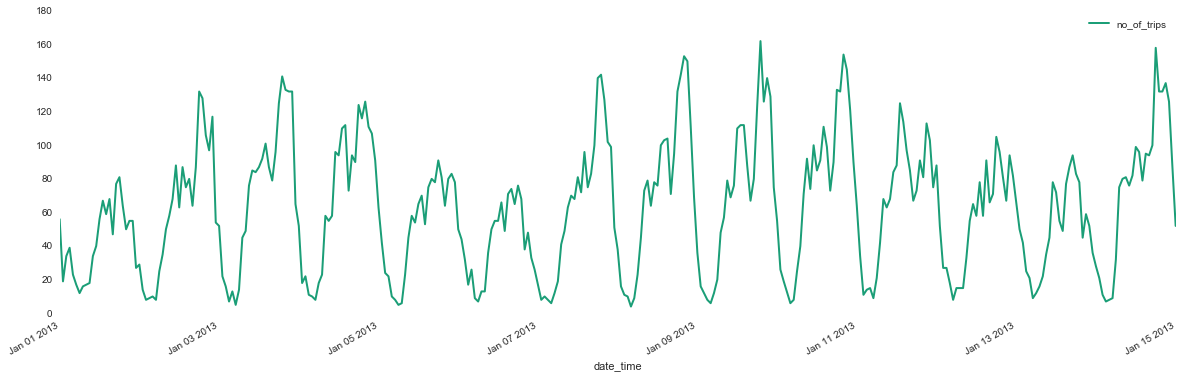

In [39]:
timeseries_midtown[(timeseries_midtown.index >= '2013-01-01 00:00:00') & (timeseries_midtown.index <= '2013-01-15 00:00:00')][['no_of_trips']].plot()

In [43]:
print('Autocorrelation daily: ', timeseries_midtown['no_of_trips'].autocorr(24))
print('Autocorrelation weekly: ', timeseries_midtown['no_of_trips'].autocorr(168))
print('Autocorrelation half_day: ', timeseries_midtown['no_of_trips'].autocorr(12))

('Autocorrelation daily: ', 0.79900662949997714)
('Autocorrelation weekly: ', 0.85688319564802495)
('Autocorrelation half_day: ', -0.31508648784349985)


,Lag,Autocorrelation
0,1,0.875299
1,2,0.707558
2,3,0.508735
3,4,0.297564
4,5,0.098172


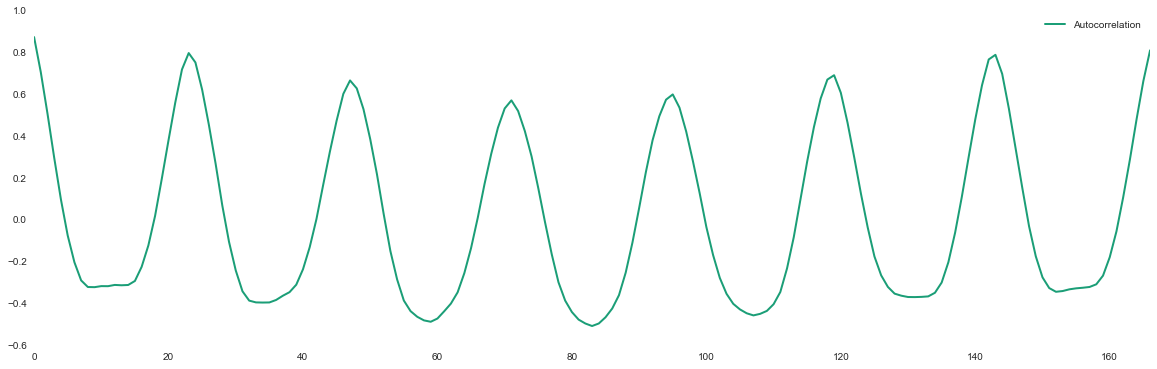

In [63]:
corr_list = []
for lag in range(1, 168):
    corr_list.append(timeseries_midtown['no_of_trips'].autocorr(lag))
corr_list_df = pd.DataFrame(data=corr_list, columns=['Autocorrelation'])
corr_list_df.plot()

def grid_search_corr(x, lag_limit):
    corr_list_dict = pd.DataFrame()
    for lag in range(1, 168):
        corr = x.autocorr(lag)
        if corr > lag_limit:
            corr_list_dict = corr_list_dict.append(pd.DataFrame(data=[[lag, corr]], columns = ['Lag','Autocorrelation']))      
    
    corr_list_dict.index = range(corr_list_dict.shape[0])
    return corr_list_dict

corr_list_df = grid_search_corr(timeseries_midtown['no_of_trips'], -0.6)
corr_list_df.head()

In [65]:
corr_list_df.sort(columns = 'Autocorrelation', ascending = False).head()

C:\Users\Anirban\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Lag,Autocorrelation
0,1,0.875299
166,167,0.812059
23,24,0.799007
143,144,0.790621
142,143,0.768469


In [75]:
n = len(timeseries_midtown['no_of_trips'])

train = timeseries_midtown['no_of_trips'][:int(.75*n)]
test = timeseries_midtown['no_of_trips'][int(.75*n):]

In [131]:
model = sm.tsa.ARIMA(train, order=(1,1,1)).fit()

predictions = model.predict(
    '2013-01-27 15:00:00',
    '2013-01-29 08:00:00',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'